In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

# Vision Transformers

In [2]:
from src.dataset import get_load_data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from __future__ import annotations
import torch.nn.functional as F

/opt/miniconda3/envs/ViT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


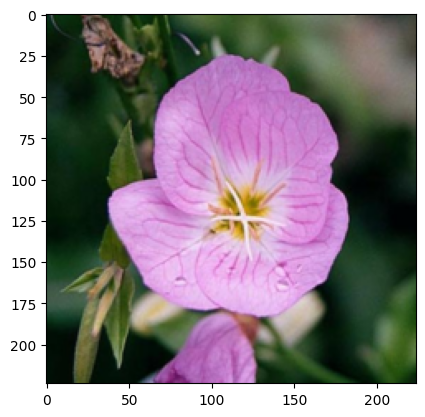

In [3]:
train, test = get_load_data(root = "../data/", dataset = "Flowers102", download = True)
img = train[0][0]
plt.imshow(img.permute(1,2,0))
plt.show()

## Patchifying the Image

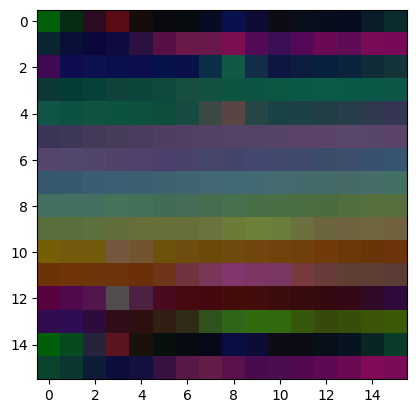

In [4]:
## Breaking up the images

patches = img.view((196,3,16,16))
plt.imshow(patches[0].permute(1,2,0))
plt.show()

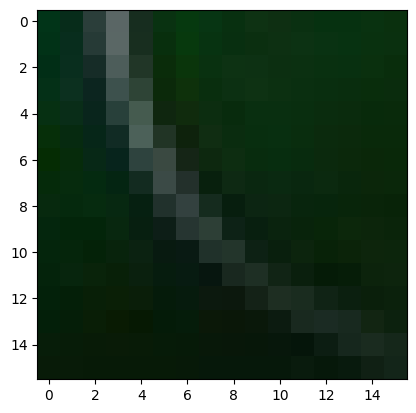

In [5]:
# real patchify
unfold = torch.nn.Unfold(kernel_size=(16, 16), stride=(16, 16))
patches = unfold(img)
patches = patches.transpose(0,1)
patches = patches.view(196, 3, 16, 16)
plt.imshow(patches[0].permute(1,2,0))
plt.show()

In [6]:
batch_size = 4
train_loader = DataLoader(train, batch_size = batch_size)

In [7]:
imgs = next(iter(train_loader))[0]
unfold = torch.nn.Unfold(kernel_size=(16, 16), stride=(16, 16))
patches = unfold(imgs)
patches = patches.transpose(1,2)
patches.shape

torch.Size([4, 196, 768])

In [8]:
# create function to patchify
# should take in BxHxWxC -> BxNx(P**2)(C)

def patchify(x: torch.Tensor) -> torch.Tensor: 
    unfold = torch.nn.Unfold(kernel_size=(16, 16), stride=(16, 16))
    patches = unfold(imgs)
    patches = patches.transpose(1,2)

    return patches

## Vision Transformer

1. Making Patches
1. Class Token
1. Positional Embeddings 
1. Transformer Encoder

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim = 8, num_heads = 2):
        super().__init__()
        self.head_size = hidden_dim // num_heads
        self.num_heads = num_heads
        self.query = nn.Linear(hidden_dim, hidden_dim, bias = True)
        self.key = nn.Linear(hidden_dim, hidden_dim, bias = True)
        self.value = nn.Linear(hidden_dim, hidden_dim, bias = True)
        self.proj = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        B, T, C = x.shape
        Q, K, V = self.query(x), self.key(x), self.value(x)
        Q, K, V = Q.view(B, self.num_heads, T, self.head_size), K.view(B, self.num_heads, T, self.head_size), V.view(B, self.num_heads, T, self.head_size)
        wei = Q @ K.transpose(-2, -1) / (self.head_size ** 0.5)
        wei = F.softmax(wei, dim = -1)
        wei = self.dropout(wei)
        out = wei @ V
        out = out.view(B, T, self.num_heads * self.head_size) 
        out = self.dropout(self.proj(out))
        return out

class TransformerEncoderLayer(nn.Module):

    def __init__(self, hidden_dim = 8, num_heads = 2):
        super().__init__()
        self.ln_1 = nn.LayerNorm(hidden_dim)
        self.ln_2 = nn.LayerNorm(hidden_dim)
        self.attn = AttentionBlock(hidden_dim, num_heads)
        self.mlp = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        out = x + self.attn(self.ln_1(x))
        out = out + self.mlp(self.ln_2(x))
        return out

class ViT(nn.Module):

    def __init__(self, 
                img_dim: Tuple[int,int,int] = (3, 224, 224), 
                patch_size: int = 16, 
                num_classes = 102,
                hidden_dim = 8,
                num_heads = 2):
        super().__init__()
        C, H, _ = img_dim
        N = int((H/patch_size) **2)
        flat_patch_dim = patch_size**2 * C
        self.hidden_dim = hidden_dim

        self.unfold = torch.nn.Unfold(kernel_size=(patch_size, patch_size), stride=(patch_size, patch_size))

        self.img_enc = nn.Linear(flat_patch_dim, hidden_dim)        
        self.pos_emb = nn.Parameter(torch.zeros((1, N + 1, hidden_dim)))
        self.cls_token = nn.Parameter(torch.randn((1, 1,hidden_dim)))
        self.t1 = TransformerEncoderLayer(hidden_dim, num_heads)
        self.mlp = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        out = self.patchify(x)
        out = self.img_enc(out)
        out = torch.cat((self.cls_token.expand(B, -1, -1), out), dim =1)
        out += self.pos_emb
        out = self.t1(out)
        out = self.mlp(out)
        return out 

    def patchify(self, x) -> torch.Tensor:

        patches = self.unfold(x)
        patches = patches.transpose(1,2)
        return patches

In [10]:
vit_model = ViT()
vit_model(imgs)

tensor([[[-8.1800e-01, -4.8250e-01,  5.2927e-02,  ...,  1.1624e+00,
           1.0048e+00,  1.9212e-03],
         [-7.3634e-01,  4.2618e-01, -6.5317e-01,  ...,  9.6637e-01,
           5.8773e-01, -2.4656e-01],
         [-1.0472e+00, -8.5584e-02,  5.4400e-01,  ...,  7.5039e-01,
           2.4837e-01, -1.7957e-01],
         ...,
         [-7.6871e-01,  7.1908e-01, -6.7844e-01,  ...,  9.4467e-01,
           3.5737e-01, -9.8940e-03],
         [-4.1091e-01,  6.5954e-01, -9.7564e-02,  ...,  8.4930e-01,
           1.9326e-01, -2.0233e-01],
         [-6.2142e-01,  5.5552e-01, -5.2018e-01,  ...,  9.3219e-01,
           3.6018e-01, -3.1734e-01]],

        [[-1.3428e+00, -3.7948e-01,  4.1055e-01,  ...,  1.2379e+00,
           7.0130e-01, -7.0053e-02],
         [-7.1745e-01,  3.6004e-01, -3.6044e-01,  ...,  6.9161e-01,
           2.7607e-01, -4.2728e-02],
         [-1.1072e+00,  9.7637e-01,  2.1483e-01,  ...,  1.5110e+00,
           3.8924e-01,  7.8531e-02],
         ...,
         [-4.1321e-01,  4

In [11]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self):
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pass

class ViT(nn.Module):

    def __init__(self):
        pass

    def forward(self, x) -> torch.Tensor:
        pass

    def patchify(self, x) -> torch.Tensor:
        pass